In [34]:
import qiskit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits import mplot3d
import mpl_toolkits.mplot3d.art3d as art3d
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.visualization import plot_bloch_multivector
from qiskit.opflow import MatrixOp, StateFn
warnings.filterwarnings('ignore', category=DeprecationWarning)

# for amplitude embedding
import pennylane as qml
from pennylane.templates.embeddings import AmplitudeEmbedding


# for loading and processing MNIST dataset
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler

# 1. Amplitude Embedding

In [39]:
# quantum device where you want to run and how many Qubits

'''
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def circuit(data):
    AmplitudeEmbedding(features=data, wires=range(2),normalize=True)
    return qml.state()

data = [6,-12.5,11.15,7]
print(circuit(data))
'''

print(np.asarray(data) / np.linalg.norm(data))


[ 0.31380835 -0.65376739  0.58316051  0.36610974]


# 2. Calculate the Distance between 2 2^N dimensional vectors

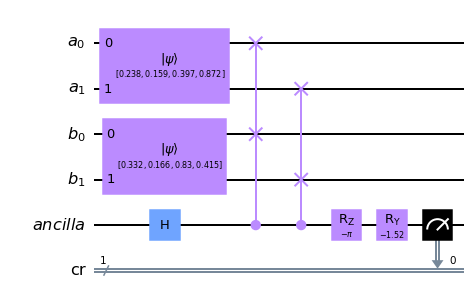

In [155]:
# Prepare classical data
N = 2
n = pow(2, N) # number of features 
a = np.asarray([3, 2, 5, 11], dtype = np.double)
b = np.asarray([4, 2, 10, 5], dtype = np.double)
# a = a/np.linalg.norm(a) # not necessary
# b = b/np.linalg.norm(b) # not necessary


# Prepare quantum states
a_reg = QuantumRegister(N, 'a')
b_reg = QuantumRegister(N, 'b')
ancilla_reg = QuantumRegister(1, 'ancilla')
cr = ClassicalRegister(1, 'cr')

circ = QuantumCircuit(a_reg, b_reg, ancilla_reg, cr)
circ.initialize(a/np.linalg.norm(a), a_reg)
circ.initialize(b/np.linalg.norm(b), b_reg)


# Entangle the ancilla with a and b
circ.h(ancilla_reg[0])
for i in range(N):
    circ.cswap(ancilla_reg[0], a_reg[i], b_reg[i])


# Prepare the projection operator
z = np.sum(np.square(a) + np.square(b))
proj_vec = np.asarray([np.linalg.norm(a)/np.sqrt(z), -1 * np.linalg.norm(a)/np.sqrt(z)])
theta = 2 * np.arccos(np.linalg.norm(a)/np.sqrt(z)) # assume a and b are both real, then proj_vec is real 
phi = 1 * np.pi # proj_vec[1] is negative

circ.rz(-1 * phi, ancilla_reg[0]) # projection = rotate then measure
circ.ry(-1 * theta, ancilla_reg[0])

# Measure
circ.measure(ancilla_reg[0], cr[0])

circ.draw(output = 'mpl')

56.696
62.0


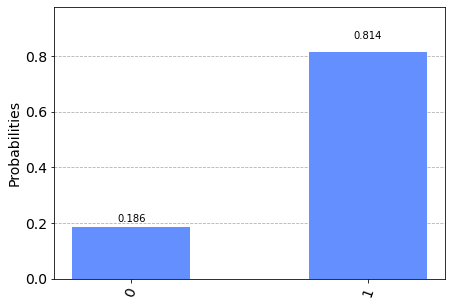

In [156]:
n_shots = 10000
results = execute(circ, Aer.get_backend('qasm_simulator'), shots=n_shots).result().get_counts()
print(results['0']/n_shots * z)
print(np.sum(np.square(a-b)))
plot_histogram(results)

# 3. Integrate with Quantum Ensemble

In [217]:
def stateprep(x_train, y_train, x_test, N, d, k):

  """
  x_train: array of training features (n_samples, 2)
  y_train: array of binary training labels (n_samples, )
  x_test: array of test features (2, )
  d: number of control qubits. Generates 2^d transformations to training data
  """

  control_reg = QuantumRegister(d, 'control')
  x_train_reg = QuantumRegister(N * k, 'x_train')
  y_train_reg = QuantumRegister(N, 'y_train')
  x_test_reg = QuantumRegister(k, 'x_test')
  prediction_reg = QuantumRegister(1, 'prediction')

  stateprep = QuantumCircuit(control_reg, x_train_reg, y_train_reg, x_test_reg, prediction_reg)

  print("done")

  #create uniform superposition of control qubits
  for i in range(d):
    stateprep.h(i)
  
  print("control qubits initialized")

  #initialize training data
  for i in range(N):
    stateprep.initialize(x_train[i]/np.linalg.norm(x_train[i]), x_train_reg[i*k : (i+1)*k])

    
  for i in range(N):
    if y_train[i] == 1:
      stateprep.initialize([0, 1], d + N * k + i)
    #else:
      #stateprep.initialize([1, 0], y_train_reg[i])


  #initialize test data
  stateprep.initialize(x_test/np.linalg.norm(x_test), x_test_reg)

  return stateprep

In [223]:
def superposition_sampler(N, d, k):

  """
  x_train: array of training features
  y_train: array of binary training labels
  x_test: array of test features
  d: number of control qubits. Generates 2^d transformations to training data
  """
  
  control_reg = QuantumRegister(d, 'control')
  x_train_reg = QuantumRegister(N * k, 'x_train')
  y_train_reg = QuantumRegister(N, 'y_train')

  sampler = QuantumCircuit(control_reg, x_train_reg, y_train_reg)

  for i in range(d):
    if(i % 2 == 0):
      for j in range(k):
        sampler.cswap(i, x_train_reg[j], x_train_reg[2*k + j])
      sampler.cswap(i, y_train_reg[0], y_train_reg[2])
      sampler.x(i)
      for j in range(k):
        sampler.cswap(i, x_train_reg[1*k + j], x_train_reg[3*k + j])
      sampler.cswap(i, y_train_reg[1], y_train_reg[3])
      sampler.barrier()
    else:
      sampler.x(i)
      for j in range(k):
            sampler.cswap(i, x_train_reg[2*k + j], x_train_reg[3*k + j])
      sampler.cswap(i, y_train_reg[2], y_train_reg[3])

  return sampler

In [219]:
def distance_classifier(N, d, k):
    '''
    N: number of training samples
    d: number of control qubits
    k: number of features
    '''
    
    control_reg = QuantumRegister(d, 'control')
    x_train_reg = QuantumRegister(N * k, 'x_train')
    y_train_reg = QuantumRegister(N, 'y_train')
    x_test_reg = QuantumRegister(k, 'x_test')
    prediction_reg = QuantumRegister(1, 'prediction')
    
    circ = QuantumCircuit(control_reg, x_train_reg, y_train_reg, x_test_reg, prediction_reg)
    
    # Entangle the ancilla with the last training example
    circ.h(prediction_reg[0])
    for i in range(k):
        circ.cswap(prediction_reg[0], x_test_reg[i], x_train_reg[(N-1) * k + i])
    
    # Suppose the data is normalized, then the projector degenerates
    # If the data is not normalized, we would need to apply controlled rotations
    z = 2
    theta = 2 * np.arccos(1/np.sqrt(z))
    phi = 1 * np.pi
    circ.rz(-1 * phi, prediction_reg[0]) # projection = rotate then measure
    circ.ry(-1 * theta, prediction_reg[0])
    
    circ.cx(y_train_reg[N-1], prediction_reg[0]) 
    circ.x(prediction_reg[0]) # to ensure that the larger the probability amplitude, the more likely the class
    
    return circ
    

In [220]:
def measure():
    
    prediction_reg = QuantumRegister(1, 'prediction')
    cr = ClassicalRegister(1, name = "cr")
    m = QuantumCircuit(prediction_reg, cr)
    m.measure(prediction_reg[0], cr[0])
    
    return m

In [221]:
def plot_data(x_train, y_train, x_test):
    '''
    x_train: (n_samples, 2)
    y_train: (n_samples, )
    x_test: (2, )
    '''
    x_test = x_test[np.newaxis, :]
    x = np.concatenate((x_train, x_test), axis = 0)
    y = np.concatenate((y_train, np.asarray([-1])), axis = 0)
    
    data = pd.DataFrame(columns = ['x1', 'x2', 'y'])
    data['x1'] = x[:, 0]
    data['x2'] = x[:, 1]
    data['y'] = y
    
    sns.catplot(x='x1', y='x2', hue='y', data=data)
    
    return

done
control qubits initialized


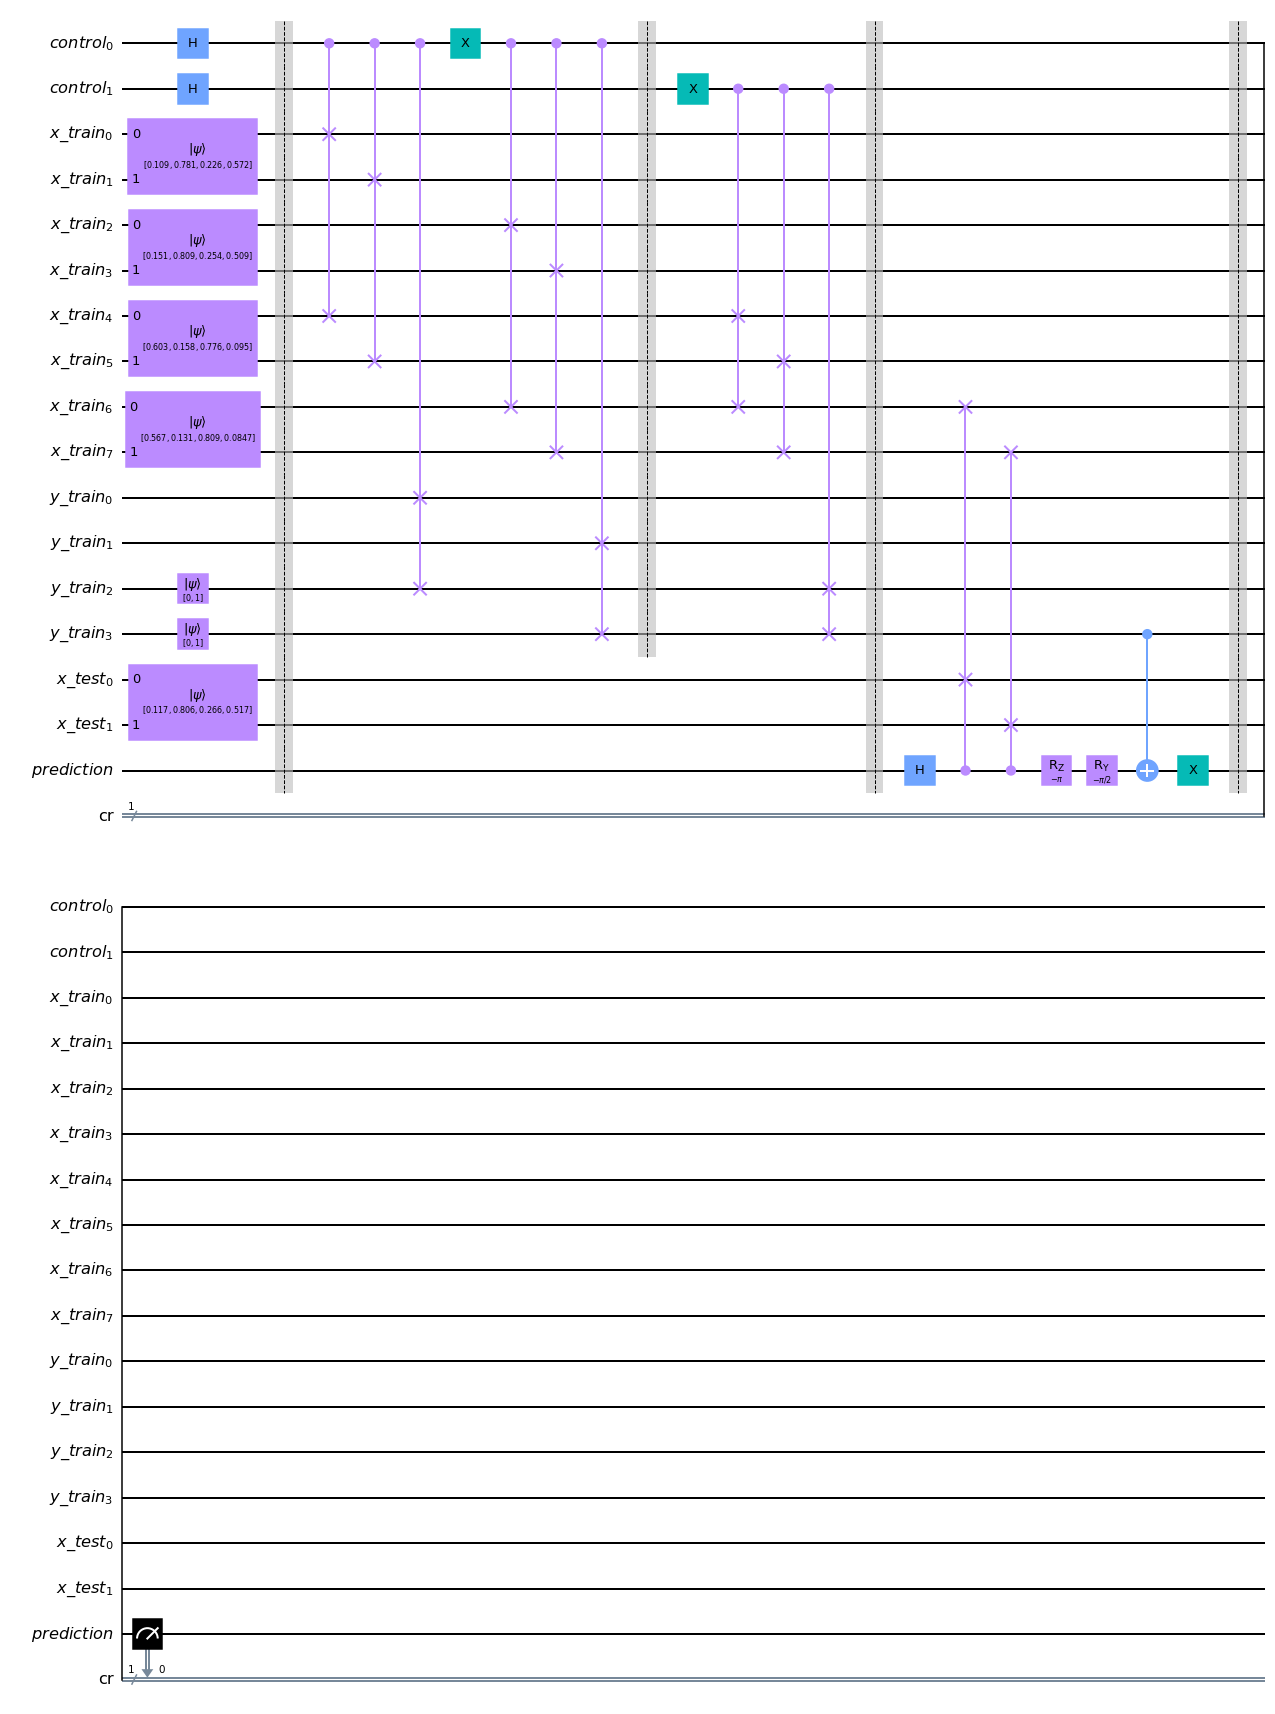

In [226]:
x_train = [[123, 879, 254, 643], [178, 954, 300, 600], [762, 200, 980, 120], [669, 155, 955, 100]] 
x_train = np.asarray(x_train)

y_train = [0, 0, 1, 1]
y_train = np.asarray(y_train)

x_test0 = [141, 970, 320, 622] # label should be 0
x_test1 = [823, 234, 923, 162] # label should be 1
x_test = np.asarray(x_test0)

# plot_data(x_train, y_train, x_test)

N = x_train.shape[0]
d = 2
k = int(np.log2(x_train.shape[1]))

circ = stateprep(x_train, y_train, x_test, N, d, k)
circ.barrier()
circ += superposition_sampler(N, d, k)
circ.barrier()
circ += distance_classifier(N, d, k)
circ.barrier()
circ += measure()
circ.draw(output = 'mpl')

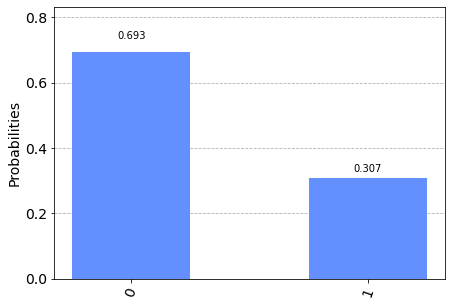

In [227]:
plot_histogram(execute(circ, Aer.get_backend('qasm_simulator'), shots=1000).result().get_counts())